In [1]:
# Connect to the GIS portal
from arcgis.gis import GIS, Item
from arcgis.mapping import WebMap
from getpass import getpass as pwd
import arcpy
import json

# Change "username" to your AGOL-username
user_name = "colin.langhorn_Yondr"
#pwd = pwd()
#source = GIS("https://yondr.maps.arcgis.com/", user_name, pwd,  expiration=9999)
source = GIS('https://gismo.yondrgroup.com/portal/home','yondr.publisher' , '7ZhHZG7ebuMHh4k')
# gis = GIS()
print (f"Successfully logged in as: {source}")

# AGOL DEV
# target = GIS('https://yondrdev.maps.arcgis.com/','YondrDev' , 'df1ZDR5vhG2a')
# GISMO
# target = GIS('https://gismo.yondrgroup.com/portal/home','yondr.publisher' , '7ZhHZG7ebuMHh4k')
target = GIS('https://dev-gis.yondrgroup.com/portal/home','portaladmin' , 'textiles.Busy.drift6')
print (f"Successfully logged in as: {target}")

Successfully logged in as: GIS @ https://gismo.yondrgroup.com/portal/home version:9.2
Successfully logged in as: GIS @ https://dev-gis.yondrgroup.com/portal/home version:9.2


In [2]:
# Copy new Features to a new folder
new_folder = 'DMA Test'
# create new folder
dest_folder = target.content.create_folder(folder=new_folder)
dest_folder

{'username': 'portaladmin',
 'id': 'e7343d8d74814be08633aed852886dca',
 'title': 'DMA Test'}

<Item title:"GISMO Map Editor Testing" type:Web Map owner:colin.langhorn@yondrgroup.com>
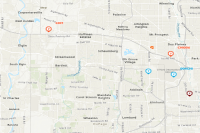

In [3]:
# WebMap_name = 'Gismo 1.0 Map'
# client_map = source.content.search(WebMap_name, item_type='Web Map')[0]
WebMap_ID = '57d7b4931eb84721a2bdf8b4fb283052'
client_map = source.content.search(WebMap_ID, item_type='Web Map')[0]
wm = WebMap(client_map)
client_map

In [4]:
# Copy The WebMap
client_map_json = client_map.get_data(try_json=True)
web_map_properties = {'title': wm.item.title,
                      'type': 'Web Map',
                      'snippet':wm.item.snippet,
                      'tags': wm.item.tags,
                      'text': json.dumps(client_map_json)}


client_map_new = target.content.add(web_map_properties)
# Copy WebMap and move into the folder
objMoved = client_map_new.move(folder=dest_folder["title"])

client_map_new


<Item title:"GISMO Map Editor Testing" type:Web Map owner:portaladmin>

In [5]:
# Build a dictionary to map the layers
# Ignores Vector Tiles and Tables
old_layers = []
for lyr in wm.layers:
    if 'url' in lyr:                
        d = {"title": lyr.title, 
             "itemId" :lyr.itemId, 
             "url": lyr.url}
        old_layers.append(d)   
    elif 'layerType' in lyr and lyr.layerType =="GroupLayer":
        for sublyr in lyr.layers:
            if 'url' in sublyr:                
                d = {"groupTitle": lyr.title,
                    "title": sublyr.title, 
                     "itemId" :sublyr.itemId, 
                     "url": sublyr.url}
                old_layers.append(d)   

old_layers

[{'title': 'Site',
  'itemId': 'ededa3460bdc489aacc8bddadeb3aaa3',
  'url': 'https://gismo.yondrgroup.com/server/rest/services/YondrData/Gismo_Site/FeatureServer/0'},
 {'title': 'Site Boundary',
  'itemId': 'ededa3460bdc489aacc8bddadeb3aaa3',
  'url': 'https://gismo.yondrgroup.com/server/rest/services/YondrData/Gismo_Site/FeatureServer/1'}]

In [6]:
layer_mapper = {}
missing_layer = {}
# Build list of features that exist already in new portal
for item in old_layers:
    # Find item in new portal based on title
    title = item['title']
    try:
        old_url = item['url']
        old_id = item['itemId']
        if 'groupTitle' in item:
            grouptitle = item['groupTitle']
            new_layer = target.content.search(grouptitle, item_type='Feature Layer')[0]
            new_id = new_layer.id
            for sublyr in new_layer.layers:
                sublyrTitle = sublyr.properties.name
                if sublyrTitle == title:
                    new_url = sublyr.url
                    layer_mapper[sublyrTitle] = { "old_url": old_url,
                        "url": sublyr.url,
                        "old_itemid": old_id,
                        "itemId" :new_id }
        else:
            new_layer = target.content.search(title, item_type='Feature Layer')[0]
            layer_mapper[title] = { "old_url": old_url,
                                    "url": new_url.url,
                                    "old_itemid": old_id,
                                    "itemId" :new_url.itemId }
    except Exception as e:
        missing_layer[title] = { 
            "title":  title,
            "old_url": old_url,
            "old_itemid": old_id }
        print(missing_layer)
        print('error', e.args[0])



{'Site': {'title': 'Site', 'old_url': 'https://gismo.yondrgroup.com/server/rest/services/YondrData/Gismo_Site/FeatureServer/0', 'old_itemid': 'ededa3460bdc489aacc8bddadeb3aaa3'}}
error name 'new_url' is not defined
{'Site': {'title': 'Site', 'old_url': 'https://gismo.yondrgroup.com/server/rest/services/YondrData/Gismo_Site/FeatureServer/0', 'old_itemid': 'ededa3460bdc489aacc8bddadeb3aaa3'}, 'Site Boundary': {'title': 'Site Boundary', 'old_url': 'https://gismo.yondrgroup.com/server/rest/services/YondrData/Gismo_Site/FeatureServer/1', 'old_itemid': 'ededa3460bdc489aacc8bddadeb3aaa3'}}
error list index out of range


In [7]:
layer_mapper

{}

In [8]:
missing_layer

{'Site': {'title': 'Site',
  'old_url': 'https://gismo.yondrgroup.com/server/rest/services/YondrData/Gismo_Site/FeatureServer/0',
  'old_itemid': 'ededa3460bdc489aacc8bddadeb3aaa3'},
 'Site Boundary': {'title': 'Site Boundary',
  'old_url': 'https://gismo.yondrgroup.com/server/rest/services/YondrData/Gismo_Site/FeatureServer/1',
  'old_itemid': 'ededa3460bdc489aacc8bddadeb3aaa3'}}

In [55]:
# Update the new webmap with layers from the same portal
wm_new = WebMap(client_map_new)
for lyr in wm_new.layers:
    try:
    # Bug with comparing arcgis vs. ArcGIS in url
        if 'layerType' in lyr and lyr.layerType =="GroupLayer":
            for sublyr in lyr.layers:
                lyrTitle = sublyr['title']
                if lyrTitle in layer_mapper:
                    sublyr['url'] = layer_mapper[lyrTitle]['url']
                    sublyr['itemId'] = layer_mapper[lyrTitle]['itemId']
                    target.update_properties(wm_new)
        elif 'url' in lyr:
            lyrTitle = lyr['title']
            if lyrTitle in layer_mapper:
                lyr['url'] = layer_mapper[lyrTitle]['url']
                lyr['itemId'] = layer_mapper[lyrTitle]['itemId']
                target.update_properties(wm_new)
        else:
            #print ("Layer Not updated: " + lyr['title'])
            pass
    except Exception as e:
        print('error', e.args[0])
wm_new.update()

True

### Update Tables
Doesn't Work

In [73]:
# Build a dictionary to map the layers
# Ignores Vector Tiles and Tables
old_tables = [] 
for tbl in wm.tables:
    print(tbl)
    if 'url' in lyr:                
        d = {"title": tbl.title, 
             "itemId" :tbl.itemId, 
             "url": tbl.url}
        old_tables.append(d)  
old_tables

{
  "id": "1843fc142e8-layer-19",
  "title": "Cable Landing Relationship",
  "url": "https://services6.arcgis.com/yoQT8hnhlucS3D19/arcgis/rest/services/SubmarineCable/FeatureServer/3",
  "itemId": "6c9b79e629f34d18aea65e32602bff64"
}
{
  "id": "1843fc11c10-layer-15",
  "title": "Fatal Flaw",
  "url": "https://utility.arcgis.com/usrsvcs/servers/4c52b7a5d2ce44bcbbab8686971ab317/rest/services/YondrData/GismoSite/FeatureServer/4",
  "itemId": "4c52b7a5d2ce44bcbbab8686971ab317"
}
{
  "id": "1843fc11c10-layer-14",
  "title": "Site Updates",
  "url": "https://utility.arcgis.com/usrsvcs/servers/4c52b7a5d2ce44bcbbab8686971ab317/rest/services/YondrData/GismoSite/FeatureServer/5",
  "itemId": "4c52b7a5d2ce44bcbbab8686971ab317",
  "formInfo": {
    "formElements": [
      {
        "label": "Site ID",
        "type": "field",
        "editable": false,
        "fieldName": "SiteID",
        "inputType": {
          "type": "text-box",
          "maxLength": 10,
          "minLength": 0
        }
 

[]

In [59]:
table_mapper = {}
missing_table = {}
# Build list of features that exist already in new portal
for item in old_tables:
    # Find item in new portal based on title
    title = item['title']
    try:
        old_url = item['url']
        old_id = item['itemId']
        print(title)
        new_table = target.content.search(title, item_type='Feature Table')[0]
        print(new_table)
        new_url = new_table.url
        new_id = new_table.id
        table_mapper[title] = { "old_url": old_url,
                                "url": lyr.url,
                                "old_itemid": old_id,
                                "itemId" :lyr.itemId }
    except Exception as e:
        missing_table[title] = { 
            "title":  title,
            "old_url": old_url,
            "old_itemid": old_id }
        # print(missing_layer)
        # print('error', e.args[0])

Cable Landing Relationship
Fatal Flaw
Site Updates


In [72]:
new_table = target.content.search(query='title:*Fatal Flaw*')
print(new_table)

[]


In [50]:
table_mapper

{}

In [51]:
missing_table

{'Cable Landing Relationship': {'title': 'Cable Landing Relationship',
  'old_url': 'https://services6.arcgis.com/yoQT8hnhlucS3D19/arcgis/rest/services/SubmarineCable/FeatureServer/3',
  'old_itemid': '6c9b79e629f34d18aea65e32602bff64'},
 'Fatal Flaw': {'title': 'Fatal Flaw',
  'old_url': 'https://utility.arcgis.com/usrsvcs/servers/4c52b7a5d2ce44bcbbab8686971ab317/rest/services/YondrData/GismoSite/FeatureServer/4',
  'old_itemid': '4c52b7a5d2ce44bcbbab8686971ab317'},
 'Site Updates': {'title': 'Site Updates',
  'old_url': 'https://utility.arcgis.com/usrsvcs/servers/4c52b7a5d2ce44bcbbab8686971ab317/rest/services/YondrData/GismoSite/FeatureServer/5',
  'old_itemid': '4c52b7a5d2ce44bcbbab8686971ab317'}}

In [42]:
for tbl in wm_new.tables:
    print(tbl)


{
  "id": "1843fc142e8-layer-19",
  "title": "Cable Landing Relationship",
  "url": "https://services6.arcgis.com/yoQT8hnhlucS3D19/arcgis/rest/services/SubmarineCable/FeatureServer/3",
  "itemId": "6c9b79e629f34d18aea65e32602bff64"
}
{
  "id": "1843fc11c10-layer-15",
  "title": "Fatal Flaw",
  "url": "https://utility.arcgis.com/usrsvcs/servers/4c52b7a5d2ce44bcbbab8686971ab317/rest/services/YondrData/GismoSite/FeatureServer/4",
  "itemId": "4c52b7a5d2ce44bcbbab8686971ab317"
}
{
  "id": "1843fc11c10-layer-14",
  "title": "Site Updates",
  "url": "https://utility.arcgis.com/usrsvcs/servers/4c52b7a5d2ce44bcbbab8686971ab317/rest/services/YondrData/GismoSite/FeatureServer/5",
  "itemId": "4c52b7a5d2ce44bcbbab8686971ab317",
  "formInfo": {
    "formElements": [
      {
        "label": "Site ID",
        "type": "field",
        "editable": false,
        "fieldName": "SiteID",
        "inputType": {
          "type": "text-box",
          "maxLength": 10,
          "minLength": 0
        }
 

### Download the Experience builder

In [76]:
# Define a function for copying the Web Experience 
import os
import uuid
import json
import shutil
import tempfile

from arcgis import __version__

_version = [int(i) for i in __version__.split('.')]

# Build some helper functions
def export_resources(item, save_path=None, file_name=None):
    """Export's the data's resources as a zip file"""
    url = \
        f'{item._gis._portal.resturl}content/users/{item._user_id}/items/{item.itemid}/resources/export'
    if save_path is None:
        save_path = tempfile.gettempdir()
    if file_name is None:
        file_name = f"{uuid.uuid4().hex[:6]}.zip"
    params = {'f' : 'zip'}
    con = item._gis._portal.con
    resources = con.get(url, params=params,
                        out_folder=save_path,
                        file_name=file_name,
                        try_json=False)
    return resources

print("Function Sucessfully Created :)")

Function Sucessfully Created :)


In [77]:
ExB_name =  'GISMO 1.0 Dev Manager App'
# Name of the new Web Experience
ExB_new = 'GISMO 1.0 Dev Manager App Test'

<Item title:"AGOL-GISMO 1.0 Dev Manager App" type:Web Experience owner:yondrgroup1>
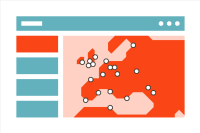

In [78]:
# Get the Client App Web Experience
client_app_id = source.content.search(ExB_name, item_type='Web Experience')[0]
client_app = source.content.get(client_app_id.id)
resource = client_app.resources.export()
client_app

In [79]:
# Collect the Web Maps and Express Maps using the Experience's data. Use the set 
# operator each item is collected only once for cloning.
client_app_json = client_app.get_data(try_json=True)

# for k, v in client_app_json['dataSources'].items():
#     print(v['type']) 

web_maps = ([v['itemId'] for k, v in client_app_json['dataSources'].items() \
                if v['type'].find('WEB_MAP')>-1])

web_maps

['36d54f58816d44c8a8c90725e0182aae']

In [80]:
# New WebMap
client_map_new

<Item title:"Gismo 1.0 Map" type:Web Map owner:yondr.publisher>

In [81]:
# Create a dictionary map of old and new item ids
webmap_mapper = {}
webmap_mapper[web_maps[0]] = client_map_new.itemid
webmap_mapper

{'36d54f58816d44c8a8c90725e0182aae': 'bc1a3b8c508d4d249c249ee14b34c449'}

In [82]:
# Replace the Web Experience Json with the new item ids
client_app_text = json.dumps(client_app_json)

for k, v in webmap_mapper.items():
    client_app_text = client_app_text.replace(k, v) # replace the IDs
    print(f'old id: {k}, new id: {v}')

old id: 36d54f58816d44c8a8c90725e0182aae, new id: bc1a3b8c508d4d249c249ee14b34c449


In [83]:
# Create the New Web Experience
new_item = source.content.add({'type' : client_app.type,
                                 'tags' : client_app.tags,
                                 'title' : ExB_new,
                                 'description' : client_app.description,
                                 'typeKeywords' : client_app.typeKeywords,
                                 'extent' : client_app.extent,
                                 'text' :client_app_text}
                                )
new_item.resources.add(resource, archive=True)

{'success': True,
 'itemId': '076654233fe445138c119cda88870196',
 'owner': 'colin.langhorn_Yondr',
 'folder': 'null'}

In [84]:
new_item.update({'url': client_app.url.replace(client_app.id, new_item.id)})

True

In [85]:
# Final modifications of Web Experience
with tempfile.NamedTemporaryFile(mode='w', suffix='.json', 
                                 dir=tempfile.gettempdir(), 
                                 delete=False) as jsonfile:
    jsonfile.write(json.dumps(new_item.get_data()))
    new_item.resources.add(file=jsonfile.name)
    type_keywords = [tk for tk in new_item.typeKeywords if 'smdraftresourceid:' not in tk]
    type_keywords.append(f'smdraftresourceid:{os.path.basename(jsonfile.name)}')
    new_item.update({'typeKeywords' : type_keywords})

# Move to the folder
new_item.move(folder=dest_folder["title"])
new_item

<Item title:"GISMO 1.0 Dev Manager App Test" type:Web Experience owner:colin.langhorn_Yondr>